## Haytham Fayek

# Speech Processing for Machine Learning: Filter banks, Mel-Frequency Cepstral Coefficients (MFCCs) and What's In-Between.

Speech processing plays an important role in any speech system whether its Automatic Speech Recognition (ASR) or speaker recognition or something else. Mel-Frequency Cepstral Coefficients (MFCCs) were very popular features for a long time; but more recently, filter banks are becoming increasingly popular. In this post, I will discuss filter banks and MFCCs and why are filter banks becoming increasingly popular.

Computing filter banks and MFCCs involve somewhat the same procedure, where in both cases filter banks are computed and with a few more extra steps MFCCs can be obtained. In a nutshell, a signal goes through a pre-emphasis filter; then gets sliced into (overlapping) frames and a window function is applied to each frame; afterwards, we do a Fourier transform on each frame (or more specifically a Short-Time Fourier Transform) and calculate the power spectrum; and subsequently compute the filter banks. To obtain MFCCs, a Discrete Cosine Transform (DCT) is applied to the filter banks retaining a number of the resulting coefficients while the rest are discarded. A final step in both cases, is mean normalization.

# Setup
For this post, I used a 16-bit PCM wav file from here, called “OSR_us_000_0010_8k.wav”, which has a sampling frequency of 8000 Hz. The wav file is a clean speech signal comprising a single voice uttering some sentences with some pauses in-between. For simplicity, I used the first 3.5 seconds of the signal which corresponds roughly to the first sentence in the wav file.

I’ll be using Python 3.7.x, NumPy and SciPy. Some of the code used in this post is based on code available in this repository.

In [1]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct

sample_rate, signal = scipy.io.wavfile.read('OSR_us_000_0010_8k.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

The raw signal has the following form in the time domain:

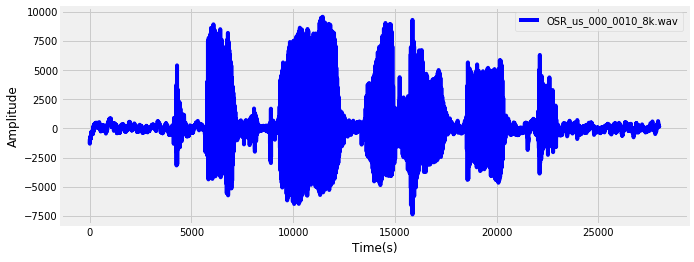

In [3]:
plt.figure(figsize=(10,4))
plt.plot(signal, c='b',label='OSR_us_000_0010_8k.wav')
plt.ylabel("Amplitude")
plt.xlabel("Time(s)")
plt.legend(loc='upper right')
plt.show()

# Pre-Emphasis
The first step is to apply a pre-emphasis filter on the signal to amplify the high frequencies. A pre-emphasis filter is useful in several ways: (1) balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies, (2) avoid numerical problems during the Fourier transform operation and (3) may also improve the Signal-to-Noise Ratio (SNR).

The pre-emphasis filter can be applied to a signal x using the first order filter in the following equation:

                                                  y(t)=x(t)−αx(t−1)
                                                  
which can be easily implemented using the following line, where typical values for the filter coefficient (α) are 0.95 or 0.97, pre_emphasis = 0.97:

emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

Pre-emphasis has a modest effect in modern systems, mainly because most of the motivations for the pre-emphasis filter can be achieved using mean normalization (discussed later in this post) except for avoiding the Fourier transform numerical issues which should not be a problem in modern FFT implementations.

The signal after pre-emphasis has the following form in the time domain:

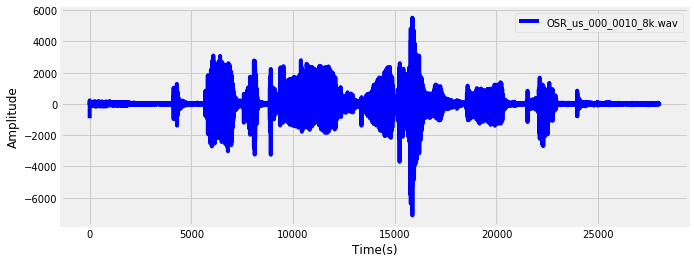

In [4]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1]) #Perfect
plt.figure(figsize=(10,4))
plt.plot(emphasized_signal, c='b',label='OSR_us_000_0010_8k.wav')
plt.ylabel("Amplitude")
plt.xlabel("Time(s)")
plt.legend(loc='upper right')
plt.show()

# Framing
After pre-emphasis, we need to split the signal into short-time frames. The rationale behind this step is that frequencies in a signal change over time, so in most cases it doesn’t make sense to do the Fourier transform across the entire signal in that we would lose the frequency contours of the signal over time. To avoid that, we can safely assume that frequencies in a signal are stationary over a very short period of time. Therefore, by doing a Fourier transform over this short-time frame, we can obtain a good approximation of the frequency contours of the signal by concatenating adjacent frames.

Typical frame sizes in speech processing range from 20 ms to 40 ms with 50% (+/-10%) overlap between consecutive frames. Popular settings are 25 ms for the frame size, frame_size = 0.025 and a 10 ms stride (15 ms overlap), frame_stride = 0.01.

In [5]:
# Split the signal into short-time frames
frame_size = 0.025
frame_stride = 0.01

# Convert from seconds to samples
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
# Make sure that we have at least 1 frame
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z)

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, 
                num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

In [6]:
frames.shape

(348, 200)

# Window
After slicing the signal into frames, we apply a window function such as the Hamming window to each frame. A Hamming window has the following form:

                                           w[n]=0.54−0.46cos(2πn/(N−1))
                                           
where, 0≤n≤N−1, N is the window length. Plotting the previous equation yields the following plot:
<img src="https://haythamfayek.com/assets/posts/post1/hamming_window.jpg" alt="Drawing" style="width: 300px;"/>
There are several reasons why we need to apply a window function to the frames, notably to counteract the assumption made by the FFT that the data is infinite and to reduce spectral leakage.

In [7]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation

In [8]:
frames.shape

(348, 200)

# Fourier-Transform and Power Spectrum
We can now do an N-point FFT on each frame to calculate the frequency spectrum, which is also called Short-Time Fourier-Transform (STFT), where N is typically 256 or 512, NFFT = 512; and then compute the power spectrum (periodogram) using the following equation:

$P=\frac{|FFT(xi)|^2}{N}$
                            
where, $\mathbf{x}_i$ is the $\mathbf{i}^{th}$ frame of signal $x$. This could be implemented with the following lines:

In [9]:
NFFT = 512 # or 256
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

# Filter Banks
The final step to computing filter banks is applying triangular filters, typically 40 filters, nfilt = 40 on a Mel-scale to the power spectrum to extract frequency bands. The Mel-scale aims to mimic the non-linear human ear perception of sound, by being more discriminative at lower frequencies and less discriminative at higher frequencies. We can convert between Hertz (f) and Mel (m) using the following equations:

$ m = 2595log_{10}(1+\frac{f}{700})$

$ f = 700(10^{\frac{m}{2595}}-1)$

Each filter in the filter bank is triangular having a response of 1 at the center frequency and decrease linearly towards 0 till it reaches the center frequencies of the two adjacent filters where the response is 0, as shown in this figure:

<img src = "https://haythamfayek.com/assets/posts/post1/mel_filters.jpg"/>

This can be modeled by the following equation (taken from [here](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)):
\begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m + 1) \\
\end{cases}

In [10]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

After applying the filter bank to the power spectrum (periodogram) of the signal, we obtain the following spectrogram:

Text(0.5, 1.0, 'the spectrum image')

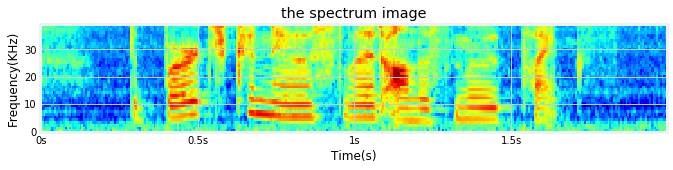

In [11]:
plt.figure(figsize=(10,2))
filter_banks -= (numpy.mean(filter_banks,axis=0) + 1e-8)
plt.imshow(filter_banks.T, cmap=plt.cm.jet, aspect='auto')
plt.xticks(numpy.arange(0, (filter_banks.T).shape[1],
int((filter_banks.T).shape[1] / 4)),
['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time(s)")
plt.ylabel("Frequency(KHz)")
plt.title('the spectrum image')

If the Mel-scaled filter banks were the desired features then we can skip to mean normalization.

# Mel-frequency Cepstral Coefficients (MFCCs)
It turns out that filter bank coefficients computed in the previous step are highly correlated, which could be problematic in some machine learning algorithms. Therefore, we can apply Discrete Cosine Transform (DCT) to decorrelate the filter bank coefficients and yield a compressed representation of the filter banks. Typically, for Automatic Speech Recognition (ASR), the resulting cepstral coefficients 2-13 are retained and the rest are discarded; num_ceps = 12. The reasons for discarding the other coefficients is that they represent fast changes in the filter bank coefficients and these fine details don’t contribute to Automatic Speech Recognition (ASR).

In [12]:
num_ceps = 12
cep_lifter = 22 #refers to the dimensionality of the MFCC vector in the original formulation.

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = numpy.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
mfcc *= lift

One may apply sinusoidal liftering1 to the MFCCs to de-emphasize higher MFCCs which has been claimed to improve speech recognition in noisy signals. The resulting MFCC:

Text(0.5, 1.0, 'Time(s)')

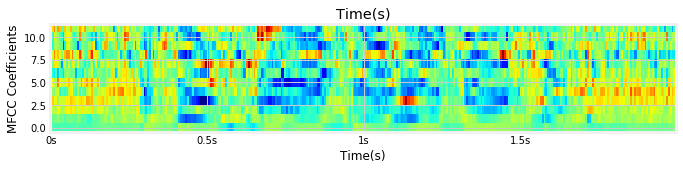

In [13]:
plt.figure(figsize=(10,2))
mfcc -= (numpy.mean(mfcc,axis=0) + 1e-8)
plt.imshow(mfcc.T, cmap=plt.cm.jet, aspect='auto')
plt.xticks(numpy.arange(0, (mfcc.T).shape[1],
int((mfcc.T).shape[1] / 4)),
['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time(s)")
plt.ylabel("MFCC Coefficients")
plt.title('Time(s)')

# Mean Normalization
As previously mentioned, to balance the spectrum and improve the Signal-to-Noise (SNR), we can simply subtract the mean of each coefficient from all frames.

In [14]:
# For Filter banks
filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
# Simlarly for MFCC
mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)

The mean-normalized filter banks:

Text(0.5, 1.0, 'the spectrum image')

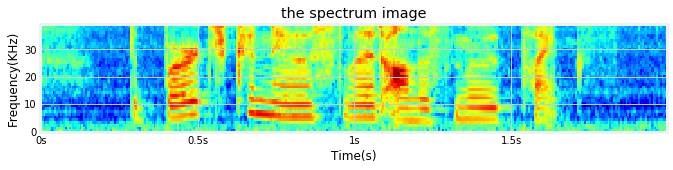

In [15]:
plt.figure(figsize=(10,2))
filter_banks -= (numpy.mean(filter_banks,axis=0) + 1e-8)
plt.imshow(filter_banks.T, cmap=plt.cm.jet, aspect='auto')
plt.xticks(numpy.arange(0, (filter_banks.T).shape[1],
int((filter_banks.T).shape[1] / 4)),
['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time(s)")
plt.ylabel("Frequency(KHz)")
plt.title('the spectrum image')

The Mean Normalised MFCC

Text(0.5, 1.0, 'Time(s)')

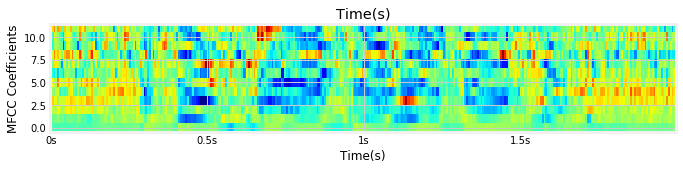

In [16]:
plt.figure(figsize=(10,2))
mfcc -= (numpy.mean(mfcc,axis=0) + 1e-8)
plt.imshow(mfcc.T, cmap=plt.cm.jet, aspect='auto')
plt.xticks(numpy.arange(0, (mfcc.T).shape[1],
int((mfcc.T).shape[1] / 4)),
['0s', '0.5s', '1s', '1.5s','2.5s','3s','3.5'])
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Time(s)")
plt.ylabel("MFCC Coefficients")
plt.title('Time(s)')

## The Rest is to get the training and testing data in .feat format using all the algorithms above.